<a href="https://colab.research.google.com/github/JackieW001/Food-Product-Sentiment-Analysis/blob/main/Sentiment_Analysis_on_Amazon_Food_Product_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis on Amazon Food Product Reviews

Timothy Shi (gs522) and Jackie Woo (jmw499)

# Notebook setup
1.   Import libraries
2.   Authorize Google client



In [ ]:
import pandas as pd
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn import metrics
from sklearn.model_selection import train_test_split
import random 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#preprocessing
from nltk.corpus import stopwords  #stopwords
from nltk import word_tokenize,sent_tokenize # tokenizing
from nltk.stem import PorterStemmer,LancasterStemmer  # using the Porter Stemmer and Lancaster Stemmer and others
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer  # lammatizer from WordNet

# for word-to-vec
import gensim

# keras
import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, LSTM, Bidirectional
from keras.models import Model
from keras.initializers import Constant
from keras.layers import ReLU
from keras.layers import Dropout

from keras.models import model_from_json
from keras.models import load_model

# for part-of-speech tagging
from nltk import pos_tag

# for named entity recognition (NER)
from nltk import ne_chunk

# vectorizers for creating the document-term-matrix (DTM)
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# BeautifulSoup libraray
from bs4 import BeautifulSoup 

import re # regex
from pprint import pprint

from pandas import DataFrame 
from sklearn.feature_extraction.text import CountVectorizer

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading Data from Kaggle

In [ ]:
# We extract the data Amazon Fine Food Reviews (https://www.kaggle.com/snap/amazon-fine-food-reviews) from kaggle
id = '1fczkNQtaNRonaITPztmoMU_pTnQh01aO'

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('googleplaystore.csv')  
df = pd.read_csv('googleplaystore.csv')
df2 = pd.read_csv('googleplaystore.csv')

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# Dataset Exploration - Visualizing the Data

Total entries (568454): 568454


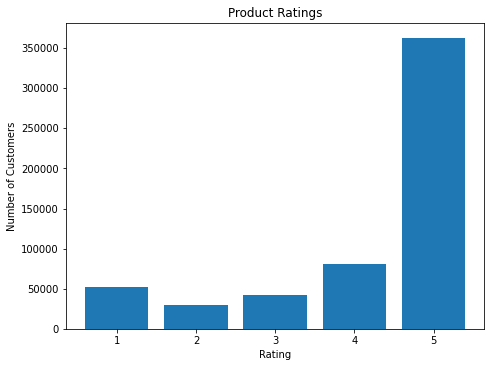

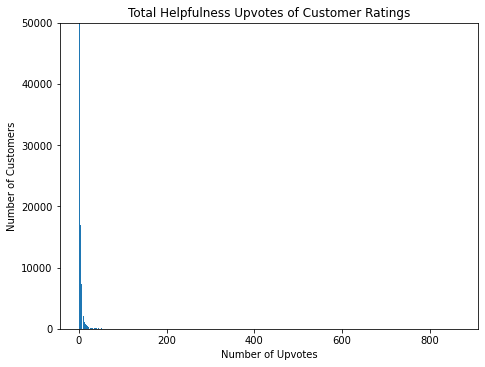

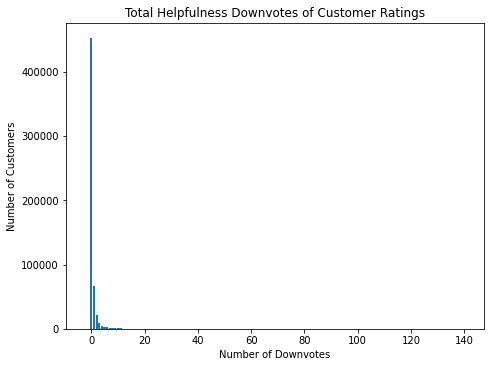

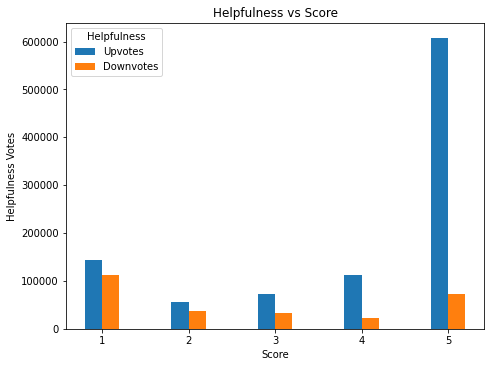

In [ ]:
# Counts frequency of numerical product ratings (1-5 stars)
product_num_rating = {}
# Counts frequency of upvotes of all product reviews
helpful_pos = {}
# Counts frequency of downvotes of all product reviews
helpful_neg = {}
# Count frequency of helpfulness upvotes/downvotes to score
upvotes_vs_score = {}
downvotes_vs_score = {}

def update_dictionary_count(dictionary, key):
    if key in dictionary:
        dictionary[key] += 1
    else:
        dictionary[key] = 1

total_entries=0
for (h_pos, h_denom, score) in zip(df['HelpfulnessNumerator'], df['HelpfulnessDenominator'], df['Score']):
  update_dictionary_count(helpful_pos, h_pos)

  h_neg = h_denom - h_pos
  update_dictionary_count(helpful_neg, h_neg)

  update_dictionary_count(product_num_rating, score)

  for i in range(h_pos):
    update_dictionary_count(upvotes_vs_score, score)
  for i in range(h_neg):
    update_dictionary_count(downvotes_vs_score, score)

  total_entries += 1

print("Total entries (568454): " + str(total_entries))

# Rating plot
rating_fig = plt.figure(figsize=(7.5,5.625)).add_subplot(111)
rating_fig.bar(product_num_rating.keys(), product_num_rating.values())
rating_fig.set_ylabel('Number of Customers')
rating_fig.set_xlabel('Rating')
rating_fig.set_title('Product Ratings')
plt.savefig("Product_Ratings.png")
plt.show()

# Upvotes plot
helpful_pos_fig = plt.figure(figsize=(7.5,5.625)).add_subplot(111)
helpful_pos_fig.bar(helpful_pos.keys(), helpful_pos.values())
helpful_pos_fig.set_ylim([0,50000])
helpful_pos_fig.set_ylabel('Number of Customers')
helpful_pos_fig.set_xlabel('Number of Upvotes')
helpful_pos_fig.set_title('Total Helpfulness Upvotes of Customer Ratings')
plt.savefig("Total_Helpfulness_Upvotes_of_Customer_Ratings.png")
plt.show()

# Downvotes plot
helpful_neg_fig = plt.figure(figsize=(7.5,5.625)).add_subplot(111)
helpful_neg_fig.bar(helpful_neg.keys(), helpful_neg.values())
helpful_neg_fig.set_ylabel('Number of Customers')
helpful_neg_fig.set_xlabel('Number of Downvotes')
helpful_neg_fig.set_title('Total Helpfulness Downvotes of Customer Ratings')
plt.savefig("Total_Helpfulness_Downvotes_of_Customer_Ratings.png")
plt.show()

# Helpfulness to Scores plot
ind = np.arange(5)  # the x locations for the groups
width = 0.2       # the width of the bars

upvotes_vs_score_lst = [upvotes_vs_score[key] for key in sorted(upvotes_vs_score.keys())]
downvotes_vs_score_lst = [downvotes_vs_score[key] for key in sorted(downvotes_vs_score.keys())]
counts = np.asarray([upvotes_vs_score_lst,downvotes_vs_score_lst])

fig, ax = plt.subplots(figsize=(7.5,5.625))

labels = ["Upvotes","Downvotes"]
for i in range(2):
  ax.bar(ind + (i*width), counts[i], width, label=labels[i])

ax.set_xticks(ind + width/2)
ax.set_xticklabels([i+1 for i in range(5)])

plt.title("Helpfulness vs Score")
plt.ylabel("Helpfulness Votes")
plt.xlabel("Score")
plt.legend(loc='best', title="Helpfulness")
plt.savefig("Helpfulness_vs_Score.png")
plt.show()

### Dataset Exploration Quick Analysis
*   Most product ratings are a 5.
*   Most product rating helpfulness is neutral (0 upvotes and 0 downvotes)
*   Most product ratings = 5 have majority number of helpfulness upvotes (helpful review for good product). Product ratings = 1 have second most number of helpfulness upvotes (helpful review for a bad product).
*   Highest number of helpfulness downvotes is when product ratings = 1



# Dataset and Text Preprocessing

In [ ]:
# extract the review text and rating
df=df[['Text','Score']]
df['review']=df['Text']
df['rating']=df['Score']
df.drop(['Text','Score'],axis=1,inplace=True)

In [ ]:
df.head()

,review,rating
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [ ]:
# any null values?
print(df['rating'].isnull().sum())
print(df['review'].isnull().sum())  
# no null values.

0
0


In [ ]:
# remove duplicate and only keep one row
df.drop_duplicates(subset=['rating','review'],keep='first',inplace=True) 
print(df.shape)
# reduce to (393675, 2)

(393675, 2)


In [ ]:
# example review:
for review in df['review'][:5]:
    print(review+'\n'+'\n')

I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".


This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.


If you are looking for the se

In [ ]:
# converting the ratings to binary 0 and 1
def mark_sentiment(rating):
  if(rating<=3):
    return 0
  else:
    return 1

df['sentiment']=df['rating'].apply(mark_sentiment)
df.drop(['rating'],axis=1,inplace=True)
df.head()

,review,sentiment
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [ ]:
df['sentiment'].value_counts()

1    306819
0     86856
Name: sentiment, dtype: int64

In [ ]:
# function to clean and pre-process the text.
def clean_reviews(review):  
    
    # 1. Removing html tags
    review_text = BeautifulSoup(review,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    review_text = re.sub("[^a-zA-Z]"," ",review_text)
    
    # 3. Converting to lower case and splitting
    word_tokens= review_text.lower().split()
    
    # 4. Remove stopwords
    le=WordNetLemmatizer()
    stop_words= set(stopwords.words("english"))     
    word_tokens= [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review=" ".join(word_tokens)
    return cleaned_review

In [ ]:
# we firstly process the first 100,000 dps 
pos_df=df.loc[df.sentiment==1,:][:50000]
neg_df=df.loc[df.sentiment==0,:][:50000]
# combining
df=pd.concat([pos_df,neg_df],ignore_index=True)
# shuffling rows
df=df.sample(frac=1).reset_index(drop=True)

In [ ]:
df.head()

,review,sentiment
0,I love a good strong cup of coffee - my favori...,0
1,We have both the Sea Salt variety and the Cinn...,0
2,Mallomars Pure Chocolate Cookies are delicious...,1
3,Expensive little buggers - sixty cents for a p...,1
4,We had mole tunnels throughout our lawn. We f...,0


#Creating Word Embeddings


In [ ]:
# Clean each sentence in each review
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sentences=[]
sum=0
ctr=0
for review in df['review']:
  sents=tokenizer.tokenize(review.strip())
  sum+=len(sents)
  for sent in sents:
    cleaned_sent=clean_reviews(sent)
    sentences.append(cleaned_sent.split()) 
print(sum)
print(len(sentences))

512639
512639


In [ ]:
df.head()

,review,sentiment
0,I love a good strong cup of coffee - my favori...,0
1,We have both the Sea Salt variety and the Cinn...,0
2,Mallomars Pure Chocolate Cookies are delicious...,1
3,Expensive little buggers - sixty cents for a p...,1
4,We had mole tunnels throughout our lawn. We f...,0


In [ ]:
# trying to print few sentences
for te in sentences[:5]:
  print(te,"\n")

['love', 'good', 'strong', 'cup', 'coffee', 'favorite', 'k', 'cup', 'green', 'mountain', 'double', 'black', 'diamond', 'extra', 'bold', 'try', 'extra', 'bold', 'variety', 'enjoy'] 

['fuhgeddabboudit', 'flavor', 'intrigued', 'pre', 'ordered', 'box', 'cup'] 

['took', 'month', 'arrive', 'tried', 'morning', 'first', 'people', 'talking', 'thing', 'making', 'mess', 'counter', 'kidding'] 

['first', 'cup', 'leaked', 'place', 'gave', 'cup', 'full', 'ground'] 

['almost', 'reluctant', 'try', 'another', 'one', 'something', 'like', 'good', 'keurig', 'machine', 'gave', 'shot', 'bad', 'measure', 'double', 'black', 'diamond', 'since', 'essentially', 'price', 'get', 'stuff', 'really', 'like', 'instead'] 



In [ ]:
# CONSTANTS
EMBED_DIM=300
WINDOW_DIM=10

In [ ]:
w2v_model=gensim.models.Word2Vec(sentences=sentences,size=EMBED_DIM,window=WINDOW_DIM,min_count=1)
w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

(38406585, 41193730)

In [ ]:
# Test gensim
w2v_model.wv.get_vector('good') # Vector representation of like
print(w2v_model.wv.similarity('good','bad')) # Similarity between two words
pprint(w2v_model.wv.most_similar('good')) # Most similar to like

0.44969347
[('great', 0.6149164438247681),
 ('decent', 0.5796770453453064),
 ('excellent', 0.4697027802467346),
 ('awesome', 0.46249526739120483),
 ('terrific', 0.46213456988334656),
 ('fantastic', 0.4605638384819031),
 ('bad', 0.4496934413909912),
 ('exceptional', 0.4280919134616852),
 ('better', 0.4265482723712921),
 ('nice', 0.40190720558166504)]


In [ ]:
# Creating dictionary of words to embeddings
vocab=w2v_model.wv.vocab
word_to_vec_dict={}
for word in vocab:
  word_to_vec_dict[word]=w2v_model.wv.get_vector(word)

In [ ]:
# Print 5 element of dictionary
print({k: word_to_vec_dict[k] for k in list(word_to_vec_dict)[:5]})

{'bought': array([-7.09572673e-01, -1.01258886e+00,  6.42910421e-01, -1.90806532e+00,
        8.20335746e-01,  1.81134725e+00, -6.03953242e-01, -4.50442821e-01,
        6.66367769e-01,  3.97452354e-01, -9.96851206e-01, -4.60490264e-04,
       -1.82739091e+00,  9.70169365e-01, -6.06805265e-01, -2.28018329e-01,
       -6.09576702e-02, -9.90471914e-02, -1.13279343e+00, -5.41511178e-01,
       -7.10484803e-01,  5.76254606e-01,  3.67624462e-01,  6.82765424e-01,
       -1.75963819e-01,  5.55677056e-01,  1.75844967e-01, -1.83854675e+00,
       -2.00102538e-01,  2.46518850e+00, -6.46217108e-01,  1.68946934e+00,
       -6.18092775e-01,  5.62025197e-02, -1.42154515e+00, -4.74701047e-01,
       -1.13164783e-01, -1.54443709e-02, -2.94415236e-01,  2.26822901e+00,
        4.34074402e-01, -1.72396731e+00, -1.70084274e+00, -7.81669933e-03,
       -1.81053668e-01,  1.77598155e+00,  6.16315365e-01,  1.81372285e+00,
       -1.58315015e+00,  1.96832073e+00,  1.46473610e+00, -8.80130291e-01,
       -7.8223

In [ ]:
# Clean sentences of unnecessary words and make all lowercase
df['clean_review']=df['review'].apply(clean_reviews)

In [ ]:
df.head()

,review,sentiment,clean_review
0,I love a good strong cup of coffee - my favori...,0,love good strong cup coffee favorite k cup gre...
1,We have both the Sea Salt variety and the Cinn...,0,sea salt variety cinn sugar sea salt variety a...
2,Mallomars Pure Chocolate Cookies are delicious...,1,mallomars pure chocolate cooky delicious tasty...
3,Expensive little buggers - sixty cents for a p...,1,expensive little bugger sixty cent piece candy...
4,We had mole tunnels throughout our lawn. We f...,0,mole tunnel throughout lawn first tried non le...


In [ ]:
# Find average document lengths to be used for padding/trimming
sum=0
maxi=-1
mini=1564
for i,rev in enumerate(df['clean_review']):
  tokens=rev.split()
  sum+=len(tokens)
  # tokens=rev.split()
  if(len(tokens)>maxi):
    maxi=len(tokens)
  if(len(tokens)<mini):
    mini=len(tokens)
avg_doc_len=int(sum/(len(df['clean_review'])))

# Print data of document lengths
print("Average document length: "+str(avg_doc_len))
print("Max document length: "+str(maxi))
print("Min document length: "+str(mini))

Average document length: 41
Max document length: 1564
Min document length: 2


In [ ]:
# Comparing document lengths
gt_avg=0
lt_avg=0
doc_len_lst=[]
for i,rev in enumerate(df['clean_review']):
  tokens_len=len(rev.split())
  doc_len_lst.append(tokens_len)
  if tokens_len > avg_doc_len:
    gt_avg+=1
  else:
    lt_avg+=1

print("Number of docs with length greater than average length: "+str(gt_avg))
print("Number of docs with length less than average length: "+str(lt_avg))

Number of docs with length greater than average length: 33268
Number of docs with length less than average length: 66732


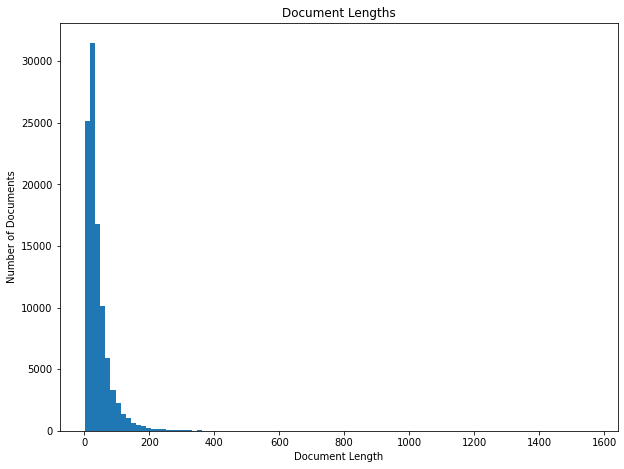

In [ ]:
# Fixing random state for reproducibility
np.random.seed(19680801)
n_bins=100

rating_fig = plt.figure(figsize=(10,7.5)).add_subplot(111)
rating_fig.hist(doc_len_lst, n_bins)
rating_fig.set_ylabel('Number of Documents')
rating_fig.set_xlabel('Document Length')
rating_fig.set_title('Document Lengths')
plt.savefig("document_lengths.png")
plt.show()

## Document Length Quick Analysis

Quick document length analysis:


*   2/3 are shorter than average documents
*   1/3 are longer than average documents
*   Max document length: 1564
*   Min document length: 2
*   Average document length: 41; Most documents close to avg document length



#Normalizing The Data

In [ ]:
# Tokenize each document
tok = Tokenizer()
tok.fit_on_texts(df['clean_review'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(df['clean_review'])

In [ ]:
# Pad each document to the average document size (41)
pad_rev= pad_sequences(encd_rev, maxlen=avg_doc_len, padding='post')
print(pad_rev.shape)
print(pad_rev[:5])

(100000, 41)
[[29239    29     5    42  2691  2358   264  7388   301  1788   844   275
   6053    12    67   844  5426   154   289   944   425 11587  2691  2620
    154   289   110  2186   289  3787  3907  2620   241   137 22650  2691
  29240  6366   569  1120 29241]
 [ 1773   495     1   266    26   270   742   224  1895   101   107  8841
   1054  3114     6     9    46  2469   264     9   130     9   264     9
    145  1923   130     9    89   505 22651     9   127    76   177    34
    477     2     4  5208    70]
 [  645    12  1306     1  2813  1192    54  1660  1459    15    52   222
   2936    83  1050   104     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0]
 [  499   216    42    84    30  3268   488    14    24  1132  1188   372
     68  3479  3542    23   571    17    17   124  3479 11096   569    68
   5501   605    10   224   414  4462   190    91   154   269     4    11


In [ ]:
# Creating the embedding matrix
# if word is not found then embed_vector corressponding to that vector will stay zero.
embed_matrix=np.zeros(shape=(vocab_size,EMBED_DIM))
for word,i in tok.word_index.items():
  embed_vector=word_to_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
print(embed_matrix[10])

[ 1.33750319  0.12581345 -0.08169003 -2.16334867 -0.20855562 -0.01589816
 -0.22413279  1.32982349 -0.93616724 -1.16105974  0.55559075  0.797822
  0.72972786  1.14656532  1.33787417 -0.0238317   1.78726459  0.55109102
 -1.49905765 -1.64861012  1.72003019 -0.54890049 -1.92500901 -0.87466472
 -1.95296705  1.58111155  1.19189858 -1.01667321 -0.07242242  0.15098421
 -0.3227261   1.3065927   2.23772669 -0.2252392   0.78230131  0.52254921
 -0.36957961  2.69132495  0.36438417 -1.26902699  0.9480716  -1.1894021
  0.97433323 -1.23013353 -0.79289579 -1.99662936  0.06928537 -1.98460865
 -1.4229753   0.81409532  1.28563511  1.63743484 -0.66707188 -0.71287483
 -0.07317875 -0.24059713 -0.9298147   0.718081    0.91923463 -0.96607792
 -0.37300846 -1.36532986  0.20984674 -0.65010095 -1.8523891  -1.81691122
 -0.4996216   1.09060633 -1.04426932 -0.23035377 -2.28389597  1.01800609
 -0.97477996 -0.93871391 -0.69001621  0.3486245  -0.52598089  1.55328822
 -0.26722738 -0.09759583  1.64442384  0.19107191  1.32

#Create Test, Train, Validation Datasets

In [ ]:
# One hot encode sentiment (y labels)
Y=keras.utils.to_categorical(df['sentiment'])

# Create train, validation sets
x_train,x_val,y_train,y_val=train_test_split(pad_rev,Y,test_size=0.20,random_state=42)

# Model Helper functions

In [ ]:
def save_model(model,filename):
  '''
  Saves model as hdf5 file

  Parameters:
    model: keras model 
      Type: keras.model
    filename: path to file
      Type: str
  '''
  assert ".h5" in filename
  model.save(filename)
  print("Saved model")

def plot_model_data(history, model_name):
  '''
  Plots accuracy and loss hisotry of a model on
  training and validation sets

  Parameters: 
    history: keras history instance
      Type: keras.callbacks.History
    model_name: name of the model (usually model<num>. Ex. model1)
      Type: str
  '''
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(model_name+"_acc.png")
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(model_name+"_loss.png")
  plt.show()

#First Model

Base model

In [ ]:
model=Sequential() # LSTM layer
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=EMBED_DIM,
    input_length=avg_doc_len,
    embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(100))
model.add(Dropout(0.50)) # Prevents overfitting by 'forgetting' weights occasinally
model.add(Dense(2,activation='sigmoid'))  # sigmod for bin. classification.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 41, 300)           16914000  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 17,074,602
Trainable params: 17,074,602
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
2500/2500 [==============================] - 587s 235ms/step - loss: 0.4036 - accuracy: 0.8226 - val_loss: 0.3632 - val_accuracy: 0.8400
Epoch 2/3
2500/2500 [==============================] - 586s 234ms/step - loss: 0.3085 - accuracy: 0.8712 - val_loss: 0.3517 - val_accuracy: 0.8465
Epoch 3/3
2500/2500 [==============================] - 586s 234ms/step - loss: 0.2413 - accuracy: 0.9019 - val_loss: 0.3850 - val_accuracy: 0.8425
Saved model


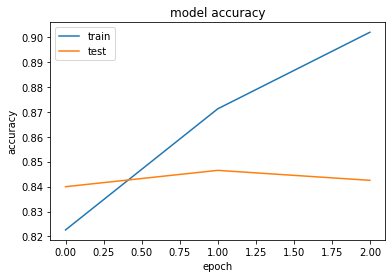

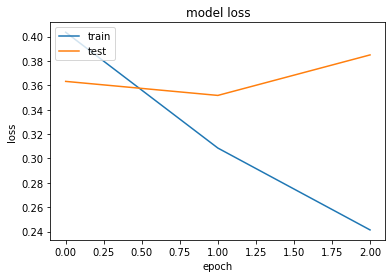

In [ ]:
# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Train model
epochs=3 # after 3 epochs, model starts to overfit (determined by seeing val_loss increase while loss deceased)
batch_size=32
history=model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val,y_val))
save_model(model, "model1.h5")

# Plot model data
plot_model_data(history, "model1")

##Results

**Analysis**: 

Model may be overfitting as shown by the validation loss increasing over epochs while training loss is decreasing. Possible fixes may be to increase dropout or lower number of epochs.

Edit: changed number epochs form 5 to 3 to stop over fitting

# Second Model

Reverse encoding

In [ ]:
model=Sequential() # LSTM layer
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=EMBED_DIM,
    input_length=avg_doc_len,
    embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(100, go_backwards=True))
model.add(Dropout(0.50)) # Prevents overfitting by 'forgetting' weights occasinally
model.add(Dense(2,activation='sigmoid'))  # sigmod for bin. classification.
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 300)           16914000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 17,074,602
Trainable params: 17,074,602
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
2500/2500 [==============================] - 392s 157ms/step - loss: 0.3947 - accuracy: 0.8262 - val_loss: 0.3563 - val_accuracy: 0.8440
Epoch 2/3
2500/2500 [==============================] - 389s 156ms/step - loss: 0.3015 - accuracy: 0.8745 - val_loss: 0.3492 - val_accuracy: 0.8478
Epoch 3/3
2500/2500 [==============================] - 391s 156ms/step - loss: 0.2348 - accuracy: 0.9043 - val_loss: 0.3877 - val_accuracy: 0.8446
Saved model


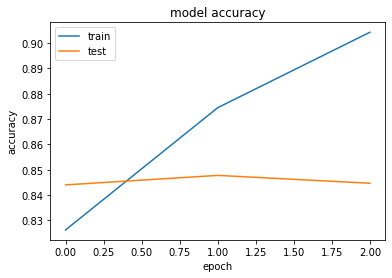

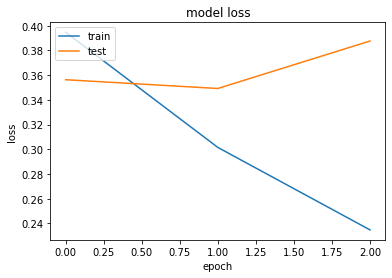

In [ ]:
# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Train model
epochs=3 # after 3 epochs, model starts to overfit (determined by seeing val_loss increase while loss deceased)
batch_size=32
history=model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val,y_val))
save_model(model, "model2.h5")

# Plot model data
plot_model_data(history, "model2")

##Results

**Analysis**

Reversing input didn't really affect the accuracy of the model. As with the base model, this model is still overfitting and has about the same accuracy.

# Third Model

Increase dropout

In [ ]:
model=Sequential() # LSTM layer
model.add(Embedding(
    input_dim=vocab_size,
    output_dim=EMBED_DIM,
    input_length=avg_doc_len,
    embeddings_initializer=Constant(embed_matrix)))
model.add(Bidirectional(LSTM(50))) # Changed for testing. Revert to 100 later
model.add(Dropout(0.85)) # Prevents overfitting by 'forgetting' weights occasinally
model.add(Dense(2,activation='sigmoid'))  # sigmod for bin. classification.
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 300)           16914000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               140400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 17,054,602
Trainable params: 17,054,602
Non-trainable params: 0
_________________________________________________________________


Epoch 1/3
2500/2500 [==============================] - 397s 159ms/step - loss: 0.4320 - accuracy: 0.8085 - val_loss: 0.3704 - val_accuracy: 0.8375
Epoch 2/3
2500/2500 [==============================] - 385s 154ms/step - loss: 0.3396 - accuracy: 0.8591 - val_loss: 0.3548 - val_accuracy: 0.8443
Epoch 3/3
2500/2500 [==============================] - 385s 154ms/step - loss: 0.2874 - accuracy: 0.8844 - val_loss: 0.3698 - val_accuracy: 0.8454
Saved model


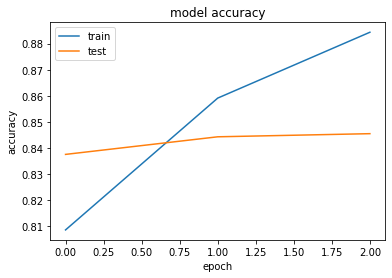

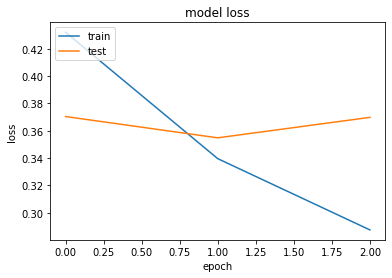

In [ ]:
# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Train model
epochs=3 # after 3 epochs, model starts to overfit (determined by seeing val_loss increase while loss deceased)
batch_size=32
history=model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val,y_val))
save_model(model, "model3.h5")

# Plot model data
plot_model_data(history, "model3")

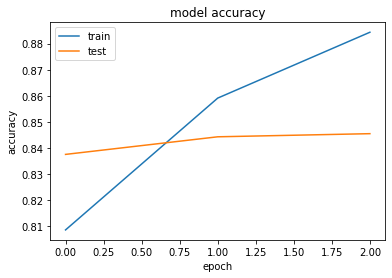

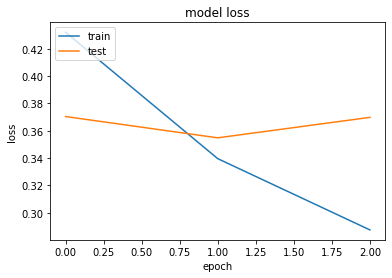

In [ ]:
plot_model_data(history, "model3") # This is from old model that didn't use lstm layer. Not sure why it did so well 

##Results

**Output** 

Epoch 1/5
938/938 [==============================] - 94s 100ms/step - loss: 0.5745 - accuracy: 0.7022 - val_loss: 0.4460 - val_accuracy: 0.8001

Epoch 2/5
938/938 [==============================] - 88s 94ms/step - loss: 0.4816 - accuracy: 0.7653 - val_loss: 0.4072 - val_accuracy: 0.8163

Epoch 3/5
938/938 [==============================] - 88s 94ms/step - loss: 0.4330 - accuracy: 0.7983 - val_loss: 0.3935 - val_accuracy: 0.8242

Epoch 4/5
938/938 [==============================] - 88s 94ms/step - loss: 0.4001 - accuracy: 0.8168 - val_loss: 0.3969 - val_accuracy: 0.8271

Epoch 5/5
938/938 [==============================] - 87s 93ms/step - loss: 0.3761 - accuracy: 0.8293 - val_loss: 0.4005 - val_accuracy: 0.8267

**Analysis**

Increased dropout from 0.5 => 0.65 made model accuracy worse but improved validation loss over epochs (continued to decrease until the last epoch)

# DEMO: Using the RNN to Predict Review Sentiment

In [ ]:
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re
from nltk.stem import WordNetLemmatizer  # lemmatizer from WordNet
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.models import load_model
from pandas import DataFrame
import numpy as np
from bs4 import BeautifulSoup 
from google.colab import drive
drive.mount('/content/drive')

# ------------------- Helper Functions ------------------------
def clean_reviews(review):  
    '''
    Clean and pre-process the text.
    parameter review: review
    parameter review type: str
    '''
    # 1. Removing html tags
    review_text = BeautifulSoup(review,"lxml").get_text()
    
    # 2. Retaining only alphabets.
    review_text = re.sub("[^a-zA-Z]"," ",review_text)
    
    # 3. Converting to lower case and splitting
    word_tokens= review_text.lower().split()
    
    # 4. Remove stopwords
    le=WordNetLemmatizer()
    stop_words= set(stopwords.words("english"))     
    word_tokens= [le.lemmatize(w) for w in word_tokens if not w in stop_words]
    
    cleaned_review=" ".join(word_tokens)
    return cleaned_review
  
def create_output_df(reviews, model_output):
  neg = []
  pos = []
  sentiment = []
  for i in model_output:
    neg.append(i[0].numpy())
    pos.append(i[1].numpy())
    sentiment.append(np.argmax(i))
  output = DataFrame({
      'Review': reviews,
      'Negative': neg,
      'Positive': pos,
      'Overall Sentiment': sentiment
    })
  return output

def predict(model, sentences_raw):
  print("Tokenizing input sentences...")
  sentences=DataFrame(sentences_raw,columns=['review'])
  sentences['clean_review']=sentences['review'].apply(clean_reviews)

  # Tokenize each document
  tok = Tokenizer()
  tok.fit_on_texts(sentences['clean_review'])
  vocab_size = len(tok.word_index) + 1
  encd_rev = tok.texts_to_sequences(sentences['clean_review'])
  # Pad each document to the average document size (41)
  pad_rev=pad_sequences(encd_rev, maxlen=41, padding='post')

  print("Predicting...")
  return create_output_df(sentences_raw, model(pad_rev))
# ------------------- End Helper Functions ------------------------

print("Loading model...")
jackie_model_path = "/content/drive/MyDrive/Junior/CS 4701 AI /model1_final.h5"
model = load_model(jackie_model_path)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive
Loading model...


In [ ]:
# -------------- Enter sentences to be predicted here --------------
reviews=[
         "I would not buy these marshmallows again.",
         "These marshmallows are too small. Would not buy again", 
         "Buy.",
         "Don't buy.",
         "All of these marshmallows were super fluffy! I made marshmallow snowmen from them.",
         "Marshmallows are made of sugar."
         ]
# ------------------------------------------------------------------

predictions = predict(model, reviews)
display(predictions)


Tokenizing input sentences...
Predicting...


,Review,Negative,Positive,Overall Sentiment
0,I would not buy these marshmallows again.,0.851062,0.149003,0
1,These marshmallows are too small. Would not bu...,0.790782,0.209907,0
2,Buy.,0.723285,0.277712,0
3,Don't buy.,0.723285,0.277712,0
4,All of these marshmallows were super fluffy! I...,0.396512,0.604108,1
5,Marshmallows are made of sugar.,0.346722,0.654181,1


#Recommendation System



In [ ]:
# we now use df2 from the previous data import
df2.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


##1. Product based collaborative filtering 

In [ ]:
# df2 is the raw data, we want to import it 
df = df2

In [ ]:
#compute the count and mean value as group by the products
count = df.groupby("ProductId", as_index=False).count()
mean = df.groupby("ProductId", as_index=False).mean()

#merge two dataset create df1
df1 = pd.merge(df, count, how='right', on=['ProductId'])

#rename column
df1["Count"] = df1["UserId_y"]
df1["Score"] = df1["Score_x"]
df1["Summary"] = df1["Summary_x"]

#Create New datafram with selected variables
df1 = df1[['ProductId','Summary','Score',"Count"]]

In [ ]:
#choose only products have over 100 reviews
df2 = df1[df1.Count >= 100]

In [ ]:
#create new dataframe as combining all summary with same product Id
df4 = df.groupby("ProductId", as_index=False).mean()
combine_summary = df2.groupby("ProductId")["Summary"].apply(list)
combine_summary = pd.DataFrame(combine_summary)
combine_summary.to_csv("combine_summary.csv")

In [ ]:
#create with certain columns
df3 = pd.read_csv("combine_summary.csv")
df3 = pd.merge(df3, df4, on="ProductId", how='inner')
df3 = df3[['ProductId','Summary','Score']]

#1a. Text Clean process - Summary column

In [ ]:
#function for tokenizing summary
cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

In [ ]:
#reset index and drop duplicate rows
df3["Summary_Clean"] = df3["Summary"].apply(cleanup)
df3 = df3.drop_duplicates(['Score'], keep='last')
df3 = df3.reset_index()

In [ ]:
docs = df3["Summary_Clean"] 
vect = CountVectorizer(max_features = 100, stop_words='english') 
X = vect.fit_transform(docs) 

df5 = DataFrame(X.A, columns=vect.get_feature_names())
df5 = df5.astype(int)

In [ ]:
#save 
df5.to_csv("df5.csv")

In [ ]:
# First let's create a dataset called X
X = np.array(df5)
 # create train and test
tpercent = 0.9
tsize = int(np.floor(tpercent * len(df5)))
df5_train = X[:tsize]
df5_test = X[tsize:]
#len of train and test
lentrain = len(df5_train)
lentest = len(df5_test)

#1b. KNN classifier to find similar products 

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df5_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = nbrs.kneighbors(df5_train)

In [ ]:
#find most related products
for i in range(lentest):
    a = nbrs.kneighbors([df5_test[i]])
    related_product_list = a[1]
    
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["ProductId"][lentrain + i] ," and this average Score is ",df3["Score"][lentrain + i])
    print ("The first similar product is ", df3["ProductId"][first_related_product] ," and this average Score is ",df3["Score"][first_related_product])
    print ("The second similar product is ", df3["ProductId"][second_related_product] ," and this average Score is ",df3["Score"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B007TGDXMU  and this average Score is  4.517006802721088
The first similar product is  B005ZBZLPI  and this average Score is  4.0
The second similar product is  B000SDKDM4  and this average Score is  4.08252427184466
-----------------------------------------------------------
Based on product reviews, for  B007TGDXNO  and this average Score is  4.3478260869565215
The first similar product is  B007TGDXMK  and this average Score is  4.143540669856459
The second similar product is  B00451WLYI  and this average Score is  4.517647058823529
-----------------------------------------------------------
Based on product reviews, for  B007TJGY5K  and this average Score is  4.119496855345912
The first similar product is  B007L3NVKU  and this average Score is  4.355072463768116
The second similar product is  B0027Z8VES  and this average Score is  4.341269841269841
-----------------------------------------------------------
Based on product reviews, for  B007TJGZ0Y  an

#1c. Predicting Review Score

In [ ]:
df5_train_target = df3["Score"][:lentrain]
df5_test_target = df3["Score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df5_train, df5_train_target)
knnpreds_test = knnclf.predict(df5_test)
print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))
print (accuracy_score(df5_test_target, knnpreds_test))

[4 4 4 3 4 4 3 3 3 4 4 3 3 3 4 4 4 3 3 3 4 3 4 3 4 3 4 4 4 4 4 4 3 4 3 4 3]
              precision    recall  f1-score   support

           3       0.50      0.80      0.62        10
           4       0.90      0.70      0.79        27

    accuracy                           0.73        37
   macro avg       0.70      0.75      0.70        37
weighted avg       0.80      0.73      0.74        37

0.7297297297297297


#2. User based collaborative filtering

In [ ]:
count = df.groupby("UserId", as_index=False).count()
mean = df.groupby("UserId", as_index=False).mean()

#merge two dataset create df1
df1 = pd.merge(df, count, how='right', on=["UserId"])
#rename column
df1["Count"] = df1["ProductId_y"]
df1["Score"] = df1["Score_x"]
df1["Summary"] = df1["Summary_x"]

#Create New datafram with selected variables
df1 = df1[["UserId",'Summary','Score',"Count"]]

In [ ]:
#choose only products have over 100 reviews
df2 = df1[df1.Count >= 100]

In [ ]:
df4 = df.groupby("UserId", as_index=False).mean()
combine_summary = df2.groupby("UserId")["Summary"].apply(list)
combine_summary = pd.DataFrame(combine_summary)
combine_summary.to_csv("combine_summary.csv")

In [ ]:
df3 = pd.read_csv("combine_summary.csv")
df3 = pd.merge(df3, df4, on="UserId", how='inner')
df3 = df3[['UserId','Summary','Score']]

In [ ]:
df3["Summary_Clean"] = df3["Summary"].apply(cleanup)
df3 = df3.drop_duplicates(['Score'], keep='last')
df3 = df3.reset_index()

In [ ]:
 docs = df3["Summary_Clean"] 
vect = CountVectorizer(max_features = 100, stop_words='english') 
X = vect.fit_transform(docs) 
#print(DataFrame(X.A, columns=vect.get_feature_names()).to_string()) 
df5 = DataFrame(X.A, columns=vect.get_feature_names())
df5 = df5.astype(int)

In [ ]:
df5.to_csv("df5.csv")
kkk  = df.drop_duplicates(['Summary'], keep='last')
kkk = kkk.reset_index()

2b. KNN classifier to find similar user and find their interesting products

In [ ]:
# First let's create a dataset called X, with 6 records and 2 features each.
X = np.array(df5)

tpercent = 0.95
tsize = int(np.floor(tpercent * len(df5)))
df5_train = X[:tsize]
df5_test = X[tsize:]

lentrain = len(df5_train)
lentest = len(df5_test)

# Next we will instantiate a nearest neighbor object, and call it nbrs. Then we will fit it to dataset X.
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(df5_train)

# Let's find the k-neighbors of each point in object X. To do that we call the kneighbors() function on object X.
distances, indices = nbrs.kneighbors(df5_train)

In [ ]:
#finding similar user and intereting products
for i in range(lentest):
    a = nbrs.kneighbors([df5_test[i]])
    related_product_list = a[1]
    
    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on  reviews, for user is ", df3["UserId"][lentrain + i])
    print ("The first similar user is ", df3["UserId"][first_related_product], ".") 
    print ("He/She likes following products")
    for i in range(295743):
        if (kkk["UserId"][i] == df3["UserId"][first_related_product]) & (kkk["Score"][i] == 5):
            aaa= kkk["ProductId"][i]
        
            print (aaa),
    print ("--------------------------------------------------------------------")

Based on  reviews, for user is  AY12DBB0U420B
The first similar user is  A3FKGKUCI3DG9U .
He/She likes following products
B007K449CE
B000EPUPSS
B000F4DKAS
B001OCBT3U
B000EMM9WG
B0014X5O1C
B004158VLU
B0018SMUVA
B004BKLHOS
B000F4J76E
B000YCJRIU
B008RWUHA6
B000MPQ4Q2
B000ETVRQS
B001E6IUMY
B000EMK4CS
B0027MIP9C
B001OCKIBY
B004FQU4CE
B000JVCBO8
B002LMXFCU
B007JT7ARQ
--------------------------------------------------------------------
Based on  reviews, for user is  AY1EF0GOH80EK
The first similar user is  AKMEY1BSHSDG7 .
He/She likes following products
B000E5AO8O
B0001UZTJG
B0009XQSAY
B000GWHFZA
B000WHPNI0
B001EQ55RW
B000EXMP74
B000NQ6TRY
B000FA38ZE
B000BLNU6E
B001EQ4J42
B00469PHX6
B000CQ4D3C
B001OCKI5U
B003ZXHB7E
B000STZRTW
B0007R9L4M
B000CBR2FS
B000E1FZJG
B000EXKS14
B0043OX51U
B001E5E060
B001EQ4HM6
B000OBYNQW
B000E1FZBY
B007TGO1U8
B000E67210
B000KNHFKU
B005G2FCNM
B0014X5O1C
B000YPMKY0
B000YW7Q0Q
B004BKLHOS
B000I60JUW
B001EQ4IKW
B001FA1KLW
B000FKQD5G
B000LKXNG2
B0014ET0OI
B000CQ4D50
B001M0

#2c.Predicting Review Score

In [ ]:
df5_train_target = df3["Score"][:lentrain]
df5_test_target = df3["Score"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(df5_train, df5_train_target)
knnpreds_test = knnclf.predict(df5_test)
print ("Predicting review score for testset user are : ", knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

Predicting review score for testset user are :  [3 4 4 4]
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       1.00      0.75      0.86         4

    accuracy                           0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4

